Creating labels for approach-2:

0 - worker

1 - worker with hat

2 - worker with vest

3 - worker with hat and vest

In [1]:
# import libraries
import matplotlib.pyplot as plt
import cv2
import glob
import os
import random
import numpy as np

Below code will create list of image names and label names from the annotations directory.

Images are resized to 960 x 544 and stored in image directory. 

Similarly annotations are in YOLO format are saved in annotations directory.

In [3]:

annotations_dir = "/home/jaydeep/pictor-ppe/data/CHV_dataset/approach-2/annotations_approach2"
annotations_fps = glob.glob(os.path.join(annotations_dir, "*.txt"))

dataset_labels = {}

for annotation_fp in annotations_fps:

    with open(annotation_fp, 'r') as annotation_file:
        annotation_data = annotation_file.readlines()

        img_annotations = []

        for annotation in annotation_data:
            data = [float(i) for i in annotation.rstrip().split(" ")]
            data[0] = int(data[0])
            img_annotations.append(data)

        img_name = os.path.basename(annotation_fp).split(".")[0] + ".jpg"
        dataset_labels[img_name] = img_annotations

In [ ]:
# This function will create image histograms to visualize images
def image_histogram_optimization(src_img):
    lab = cv2.cvtColor(src_img, cv2.COLOR_BGR2LAB)
    lightness, redness, yellowness = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(8, 8))
    corrected_lightness = clahe.apply(lightness)
    limg = cv2.merge((corrected_lightness, redness, yellowness))
    adjusted = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    return adjusted

In [1]:
# Funtion to compute bounding box intersection over union

def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# print(f'InterArea: {interArea}')
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

In [2]:
# This functions creates labels in KITTI format, it has below worker classes 
# worker
# workerhelmet
# worketvest
# workerhelmetvest

def create_kitti_labels(dataset_labels, image_name):

    for _ in range(1):

        # img_name, bbs = random.choice(list(dataset_labels.items()))

        img_name, bbs = image_name, dataset_labels[image_name]

        # print(f"Image: {img_name} and Bounding box: {bbs}")
        img_fp = os.path.join("/home/jaydeep/pictor-ppe/data/CHV_dataset/approach-2/images",img_name)
        label_name = image_name.replace('jpg','txt')
        img = cv2.imread(img_fp)
        persons = []
        vests = []
        helmets = []

        # YOLO to KITTI format converter section
        for bb in bbs:

            w = (img.shape[1]*bb[3])/2
            h = (img.shape[0]*bb[4])/2

            x = img.shape[1]*bb[1]
            y = img.shape[0]*bb[2]

            x1 = int(x - w)
            y1 = int(y - h)
            x2 = int(x + w)
            y2 = int(y + h)
            # print(x1,y1,x2,y2)

            if bb[0] == 0:
                # cv2.rectangle(img,(x1,y1),(x2,y2),(255,255,255),6)
                persons.append([x1,y1,x2,y2])
            elif bb[0] == 1:
                # cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0),6)
                vests.append([x1,y1,x2,y2])
            else:
                helmets.append([x1,y1,x2,y2])


        persons_iou_helmet = [0.0]*len(persons)
        persons_iou_vest = [0.0]*len(persons)

        person_worker = []
        helmet_flag = 0
        vest_flag = 0
        person_helmet = []
        person_vest = []
        person_no_hat_vest = []
        
        # print(f'Person IOU Initialize: {persons_iou}')

        for i, person in enumerate(persons):
            # print(f'\nIterating for Person: {i}')
            for helmet in helmets:
                # print('Inside helmet loop')
                iou_helmet = bb_intersection_over_union(person, helmet)
                # print(f'IOU bb_int person helmet: {iou_helmet}')

                # IOU threshold to check if a helmet belongs to a particular person
                if iou_helmet > 0.020: #persons_iou_helmet[i]:
                    persons_iou_helmet[i] = iou_helmet
                    helmet_flag = 1
                    # print(f'Person Bbox: {person}')
                    # print(f'Helmet Bbox: {helmet}\n')
                    person_helmet.append(helmet)

            for vest in vests:
                # print('Inside Vest loop')
                iou_vest = bb_intersection_over_union(person, vest)
                # print(f'IOU bb_int person vest: {iou_vest}')

                # IOU threshold to check if a vest belongs to a particular person
                if iou_vest > 0.15: #persons_iou_vest[i]:
                    persons_iou_vest[i] = iou_vest
                    vest_flag = 1
                    # print(f'Person Bbox: {person}')
                    # print(f'Vest Bbox: {vest}\n')
                    person_vest.append(vest)
            
            if helmet_flag and vest_flag:
                # print(f'Person {i} is wearing both helmet and vest')
                worker_class = 'workerhelmetvest'
                person_worker.append(worker_class)
                person_worker.append(person)
                person_worker.extend(person_helmet)
                person_worker.extend(person_vest)
                # print(f'\nPerson with both helmet and vest: {person_worker}')
                
            elif helmet_flag:
                # print(f'Person {i} is wearing only helmet')
                worker_class = 'workerhelmet'
                person_worker.append(worker_class)
                person_worker.append(person)
                person_worker.extend(person_helmet)
                # print(f'\nPerson with only helmet: {person_worker}')

            elif vest_flag:
                # print(f'Person {i} is wearing only vest')
                worker_class = 'workervest'
                person_worker.append(worker_class)
                person_worker.append(person)
                person_worker.extend(person_vest)
                # print(f'\nPerson with only vest: {person_worker}')
                
            else:
                # print(f'Person {i} is not wearing helmet or vest')
                worker_class = 'worker'
                person_worker.append(worker_class)
                person_worker.append(person_no_hat_vest)
                # print(f'\nPerson with no helmet and vest: {person_worker}')

            helmet_flag = 0
            vest_flag = 0
            person_helmet = []
            person_vest = []
            person_worker = []
            
            line_to_write = '{} {} {} {} {} {} {} {} {} {} {} {} {} {} {}\n'.format(worker_class, 0, 0, 0, int(person[0]), 
                                                                                int(person[1]), int(person[2]), int(person[3]), 
																				0, 0, 0, 0, 0, 0, 0)
            # print(f'Label file: {label_name}')
            # print(f'Label name: {line_to_write}')
            label_fp = os.path.join("/home/jaydeep/pictor-ppe/data/CHV_dataset/approach-2/labels_approach_2/", label_name)
            
            with open(label_fp, "a") as fp:
                fp.write(line_to_write)

        for person in persons:
            mask = np.zeros(img.shape[:2], np.uint8)
            mask[person[1]:person[3], person[0]:person[2]] = 255

            color = ('b','g','r')
            for i,col in enumerate(color):
                img_ = image_histogram_optimization(img)
                histr = cv2.calcHist([img_],[i], mask,[256],[0,256])
                # plt.plot(histr,color = col)
                # plt.xlim([0,256])
            plt.show()
            masked_img = cv2.bitwise_and(img,img,mask = mask)
            plt.imshow(masked_img[:, :, ::-1])
            plt.show()
        
        for vest in vests:
            mask = np.zeros(img.shape[:2], np.uint8)
            mask[vest[1]:vest[3], vest[0]:vest[2]] = 255

            color = ('b','g','r')
            for i,col in enumerate(color):
                img_ = image_histogram_optimization(img)
                histr = cv2.calcHist([img_],[i], mask,[256],[0,256])
                plt.plot(histr,color = col)
                plt.xlim([0,256])
            plt.show()
            masked_img = cv2.bitwise_and(img,img,mask = mask)
            plt.imshow(masked_img[:, :, ::-1])
            plt.show()
        
        for helmet in helmets:
            mask = np.zeros(img.shape[:2], np.uint8)
            mask[helmet[1]:helmet[3], helmet[0]:helmet[2]] = 255

            color = ('b','g','r')
            for i,col in enumerate(color):
                img_ = image_histogram_optimization(img)
                histr = cv2.calcHist([img_],[i], mask,[256],[0,256])
                plt.plot(histr,color = col)
                plt.xlim([0,256])
            plt.show()
            masked_img = cv2.bitwise_and(img,img,mask = mask)
            plt.imshow(masked_img[:, :, ::-1])
            plt.show()
        #     break
        # print(f'Person Hat IOU after loop: {persons_iou_helmet}')
        # print(f'Person Vest IOU after loop: {persons_iou_vest}')
        # x = np.array(persons_iou)
        # x_ids = np.argsort(x)

    # print(f'\nPersons : {persons}')
    # print(f'Helmets: {helmets}')
    # print(f'Vests: {vests}')





Below code is to visualise objects and PPE

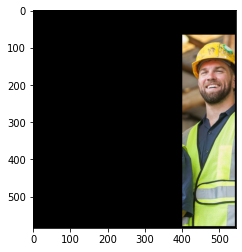

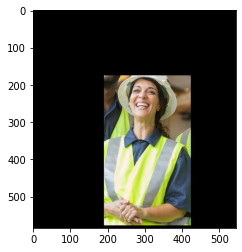

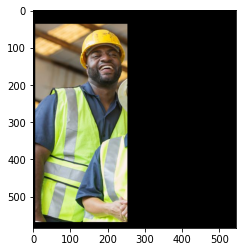

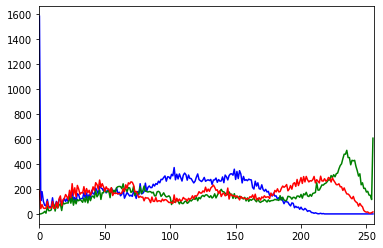

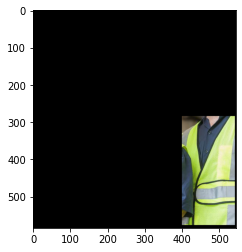

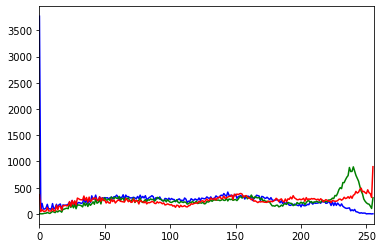

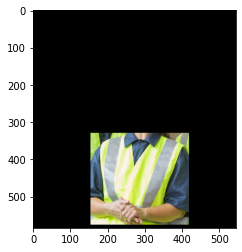

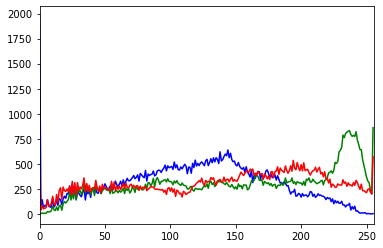

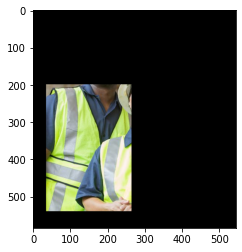

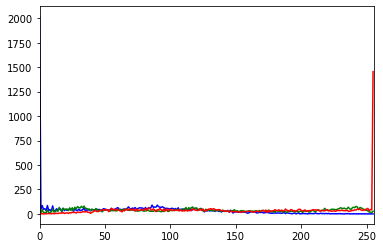

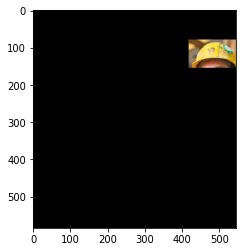

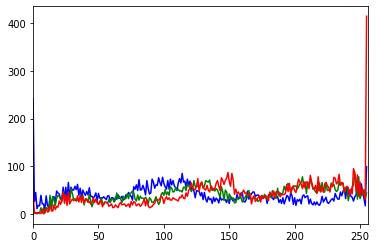

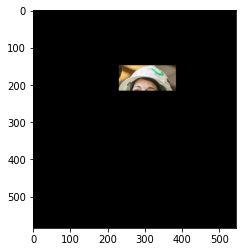

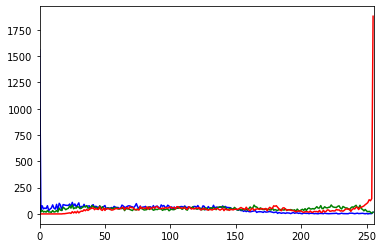

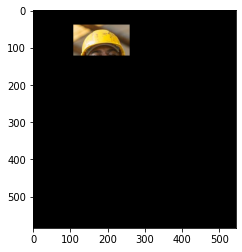

In [7]:
create_kitti_labels(dataset_labels, "ppe_0306.jpg")

Below code was used to create labels for all image files present in the image directory

In [11]:
for image in dataset_labels.keys():
    create_kitti_labels(dataset_labels,image)

Below code snippets represent the before and after images samples of resized image.
Image is resized to 960 x 544 as a standard image size to train an object detector model in TAO

In [5]:
def imageShape(image_fp):
    # image_fp = os.path.join("/home/jaydeep/pictor-ppe/data/CHV_dataset/approach-2/resized_images",image)
    image = cv2.imread(image_fp)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    return image.shape
    print(f'Shape of Image: {image.shape}')

(2073, 3960, 3)

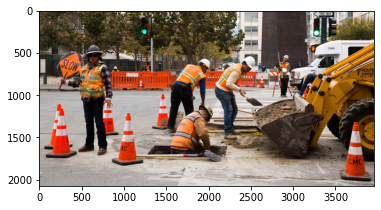

In [11]:
imageShape('/home/jaydeep/pictor-ppe/data/CHV_dataset/images/ppe_1000.jpg')

(285, 544, 3)

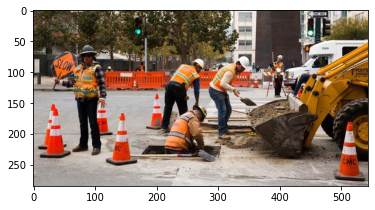

In [10]:
imageShape('/home/jaydeep/pictor-ppe/data/CHV_dataset/resized_images/total/images/ppe_1000.jpg')

Below function will display image along with ground truth labels inferred on that image

In [14]:
def draw_examples(image_name):
    # path 
    path = "/home/jaydeep/pictor-ppe/data/CHV_dataset/approach-2"
    image_path = os.path.join(path, "images", image_name)
    label_path = os.path.join(path, "labels_approach_2", image_name.replace('jpg','txt'))
    
    # Reading an image in default mode
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    print(f'Image shape: {image.shape}')
    
    # Reading labels
    with open(label_path, "r") as fp:
        lines = fp.readlines()
    thickness = 5
    print(lines)
    bbox0 = lines[0].strip().split(' ')
    start_point0 = (int(bbox0[4]), int(bbox0[5]))
    end_point0 = (int(bbox0[6]), int(bbox0[7]))
    color0 = (255, 0, 0)
    print(f'Bbox0: {start_point0,end_point0}')

    if len(lines) > 1:
        bbox1 = lines[1].strip().split(' ')

        start_point1 = (int(bbox1[4]), int(bbox1[5]))
        end_point1 = (int(bbox1[6]), int(bbox1[7]))
        color1 = (0, 0, 255)
        print(f'Bbox1: {start_point1,end_point1}')
        image1 = cv2.rectangle(image, start_point1, end_point1, color1, thickness)
    
    if len(lines) > 2:
        bbox1 = lines[2].strip().split(' ')

        start_point2 = (int(bbox1[4]), int(bbox1[5]))
        end_point2 = (int(bbox1[6]), int(bbox1[7]))
        color2 = (0, 255, 0)
        print(f'Bbox1: {start_point2,end_point2}')
        image1 = cv2.rectangle(image, start_point2, end_point2, color2, thickness)
    
    image0 = cv2.rectangle(image, start_point0, end_point0, color0, thickness)
    # print(f
    
    # Displaying the image 
    plt.imshow(image)

Image shape: (335, 544, 3)
['workerhelmetvest 0 0 0 281 42 434 334 0 0 0 0 0 0 0\n', 'workerhelmet 0 0 0 123 62 293 333 0 0 0 0 0 0 0\n']
Bbox0: ((281, 42), (434, 334))
Bbox1: ((123, 62), (293, 333))


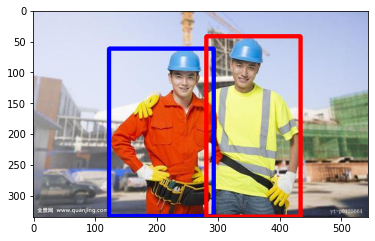

In [17]:
draw_examples('ppe_0080.jpg')

References:

- https://automaticaddison.com/how-to-apply-a-mask-to-an-image-using-opencv/ 

- https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/

- https://github.com/zarar7576/YOLO_TO_KITTI 